# Esame I appello ML

Anisa Bakiu

dovevi creare un dataset con make classification  con i parametri che ti chiede  e fare 2 pipeline che differenziano per la riduzione della dimensionalità con modello fisso non parametrico basato su prototipi e distanze.
+ fine tuning degli iper parametri sia per la rid della dim sia per il modello
+ valutare l’algoritmo migliore in base alla AUC-ROC

dataset N >= 1000 esempi, classificazione, costruire 2 pipeline con preprocessing,  \
meccanismi diversi di riduzione della dimensionalita', mettiamo un classificatore basato su prototipi. 
Il tutto va in CV annidate, per variare il test set internamente per gli iperparametri.  \
Confronto con AUC

## Dataset

In [1]:
from sklearn.datasets import make_classification

# La funzione del modulo `sklearn.datasets` permette di generare un dataset sintetico per problemi di classificazione supervisionata. `make_classification`
# X rappresenta le features, y rappresenta le etichette corrispondenti a ciascun campione
# Quando non sono specificati altri parametri, il numero di features (ossia colonne di X) sarà 20 come valore di default
X, y = make_classification(
    n_samples=2000 # numero di campioni
)

print('X shape', X.shape) # 2000 campioni (osservazioni) e 20 features
print('y shape', y.shape) # 2000 etichette

list(y[:5]) # le prime 5 etichette di y, che di default sono etichette binarie {0, 1}

X shape (2000, 20)
y shape (2000,)


[1, 0, 0, 1, 1]

## Nested CV con probability
Questo chunk definisce una funzione per effettuare la Nest Cross-Validation.

I parametri sono:
+ model: il modello da valutare (es. KNN o SVM)
+ param_grid: una griglia di iperparametri da esplorare con GridSearchCV
+ X: matrice delle feature
+ y: etichette di output
+ outer_splits: numero di partizioni per la cross-validation esterna
+ inner_splits: numero di partizioni per la cross-validation interna (durante la ricerca degli iperparametri)
+ scoring: metriche da calcolare (di default: accuracy e roc_auc)
+ verbose: se impostato stampa messaggi per seguire il processo

In [2]:
# Il modulo KFold è utilizzato per effettuare la suddivisione in k partizioni (fold) del dataset, di cui una è usata come test set e le altre per il training
# GridSearchCV è una tecnica di ricerca iperparametri che esegue la cross-validation su un insieme di valori specificati in una griglia e restituisce il miglior modello per i parametri specificati
from sklearn.model_selection import KFold, GridSearchCV
# Metriche per valutare la qualità delle predizioni del modello:
# Accuracy: percentuale di campioni correttamente classificati
# AUC-ROC Area sotto la curva ROC, utile in contesti di classificazione binaria per misurare la capacità del modello di distinguere tra le classi
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

def nested_cv(model, param_grid, X, y, outer_splits=5,
              inner_splits=5, scoring=['accuracy', 'roc_auc'],
              random_state=42, verbose=True):

    # CROSS-VALIDATION ESTERNA
    # definisco un oggetto KFold che suddivide i dati in outer_splits partizioni
    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=random_state)
    # dizionario per memorizzare i risultati delle metriche per ogni fold
    score_results = {metric: [] for metric in scoring}

    # tiene traccia dei migliori iperparametri selezionati nel processo.
    best_param_overall = None
    # tiene traccia del miglior punteggio ottenuto durante la CV.
    best_score = -np.inf 

    # CICLO SUI FOLD ESTERNI: Si itera attraverso i `outer_splits` fold generati da `KFold`
    for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), 1):
        if verbose:
            print(f"\nPerforming Outer Fold {outer_fold}/{outer_splits}")

        # test_idx e train_idx sono gli indici per la partizione di addestramento e test.
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # GridSearchCV (Cross-Validation interna)
        # Per ogni fold esterno, viene effettuata una ricerca degli iperparametri sul set di addestramento tramite GridSearchCV.
        inner_cv = KFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
        if verbose:
            print("Performing GridSearchCV...")

        # definisce la suddivisione dei dati per la ricerca degli iperparametri
        grid_search = GridSearchCV(model, param_grid, cv=inner_cv,
                                   n_jobs=-1, scoring=scoring[0])

        # addestra il modello su ogni combinazione degli iperparametri definiti in param_grid.
        grid_search.fit(X_train, y_train)

        # ottieni il parametro ottimale per i parametri scelti
        best_model = grid_search.best_estimator_
        # migliori parametri per il modello ottimale
        best_params = grid_search.best_params_

        if verbose:
            print(f" Best Params: {best_params}")

        # predicted labels con il modello ottimale
        y_pred = best_model.predict(X_test)

        # calcolo delle metriche
        if 'accuracy' in scoring:
            acc = accuracy_score(y_test, y_pred)
            score_results['accuracy'].append(acc)
            if acc > best_score:
                best_score = acc
                best_param_overall = best_params
            if verbose:
                print(f" Accuracy: {acc:.4f}")

        if 'roc_auc' in scoring:
            try:
                # calcolata a partire dalle probabilità di appartenenza alle classi, se supportate dal modello (vedi `predict_proba`)
                y_score = best_model.predict_proba(X_test)[:, 1]  
                auc = roc_auc_score(y_test, y_score)
                score_results['roc_auc'].append(auc)
                if verbose:
                    print(f" AUC: {auc:.4f}")
            except AttributeError:
                if verbose:
                    print("Controlla se ha l'opzione di probability.")
                score_results['roc_auc'].append(np.nan)

    # Si calcolano le medie (`mean`) e deviazioni standard (`std`) per ogni metrica durante i fold esterni.
    result = {}
    for metric, scores in score_results.items():
        result[f"Nested CV {metric.upper()}"] = f"{np.nanmean(scores):.4f} ± {np.nanstd(scores):.4f}"
    # - Si registra anche il miglior set di iperparametri ottenuto.
    # L'output è un dizionario con tutte le informazioni.

    result["Best Parameters with highest accuracy"] = best_param_overall

    return result

## PCA

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import time # per misurare il tempo di esecuzione

# In questa pipeline concateniamo uno scaler, una pcu per ridurre la dimensionalità e un knn per classificare
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()), # Scaling dei dati per averli con media 0 e varianza 1
    ('pca', PCA()), # PCA per riduzione delle feature
    ('knn', KNeighborsClassifier()) # Classificatore KNN
])

# dizionario con i parametri della griglia
params_grid_knn = {
    'pca__n_components': [2, 3], # numero di componenti principali da mantenere dopo la PCA
    'knn__n_neighbors': [3, 5, 7], # numero di vicini utilizzati per la classificazione
    # peso assegnato ai vicini durante la classificazione
    # uniform: tutti i vicini contribuiscono uniformemente
    # distance: i vicini più vicini hanno un peso maggiore
    'knn__weights': ['uniform', 'distance'],
    # distanza utilizzata per valutare la somiglianza tra le osservazioni (samples)
    'knn__metric': ['euclidean', 'manhattan']
}

In [4]:
start_time = time.time() # timestamp prima di eseguire nested cv


# dizionario con performance media e deviazione standard per ogni metrica
results_knn = nested_cv(pipeline_knn, params_grid_knn, X, y,
                        # 25 modelli totali (5 x 5), ciascuno ottimizzato su parametri differenti
                        outer_splits=5, inner_splits=5,
                        scoring=['accuracy', 'roc_auc'])

end_time = time.time() # timestamp dopo aver eseguito nested cv

print(f'Results knn: \n{results_knn}')
print(f'Tempo di esecuzione (knn): {end_time - start_time:.2f} secondi')


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'uniform', 'pca__n_components': 3}
 Accuracy: 0.8250
 AUC: 0.8932

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance', 'pca__n_components': 3}
 Accuracy: 0.8375
 AUC: 0.9031

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'uniform', 'pca__n_components': 3}
 Accuracy: 0.7800
 AUC: 0.8518

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'distance', 'pca__n_components': 3}
 Accuracy: 0.8375
 AUC: 0.9242

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'uniform', 'pca__n_components': 3}
 Accuracy: 0.8550
 

## Altra riduzione

## Kernel PCA

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import time

pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('kpca', KernelPCA()),
    ('knn', KNeighborsClassifier())
])

params_grid_knn = {
    'kpca__n_components': [2, 3],
    'kpca__kernel': ['linear', 'rbf', 'poly'],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

In [6]:
start_time = time.time()

results_knn = nested_cv(pipeline_knn, params_grid_knn, X, y,
                        outer_splits=5, inner_splits=5,
                        scoring=['accuracy', 'roc_auc'])

end_time = time.time()

print(f'Results knn: \n{results_knn}')
print(f'Tempo di esecuzione (knn): {end_time - start_time:.2f} secondi')


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'uniform', 'kpca__kernel': 'poly', 'kpca__n_components': 3}
 Accuracy: 0.8575
 AUC: 0.9076

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'uniform', 'kpca__kernel': 'poly', 'kpca__n_components': 3}
 Accuracy: 0.8575
 AUC: 0.9137

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'uniform', 'kpca__kernel': 'rbf', 'kpca__n_components': 2}
 Accuracy: 0.8400
 AUC: 0.8938

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'uniform', 'kpca__kernel': 'rbf', 'kpca__n_components': 2}
 Accuracy: 0.8850
 AUC: 0.9451

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'knn__metric': 'euclidean

# Altri metodi di riduzione della dimensionalita

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Questo blocco di codice usa la cross-validation (CV) semplice per valutare le prestazioni di un modello e standardizza i dati in modo che siano pronti per essere analizzati.

In [8]:
# cross_val_score calcola gli scores del modello usando la cv specificata
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

def evaluate_with_kfold(model, X, y, n_splits=5):

    # verifica delle dimensioni per assicurarsi che il numero di campioni in X corrisponda al numero di etichette
    if len(X) != len(y):
        print(f"Error: Mismatched lengths - X: {len(X)}, y: {len(y)}")
        return None

    # definizione del k-fold
    # n_splits specifica il numero di fold
    # shuffle mischia i dati prima di suddividerli

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    try:
        # valutazione del modello in ogni modello in ognuno dei fold
        scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

        # media e deviazione standard dei punteggi sui fold
        mean_acc = np.mean(scores)
        std_acc = np.std(scores)
        print(f"Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
        return mean_acc, std_acc
    except ValueError as e:
        print(f"Error during cross-validation: {e}")
        return None

X_std = scaler.fit_transform(X)

Questo blocco di codice definisce la funzione **`best_manifold`**, che viene utilizzata per determinare i parametri migliori di un dato modello di riduzione della dimensionalità utilizzando una griglia di parametri e metriche specifiche.

+ X: Dataset delle feature in input
+ y: etichette
+ model: un modello di embedding non supervisionato (e.g. TSNE, MDS, KernelPCA, ecc.)
+ param_grid: griglia di parametri del modello da esplorare
+ metric: la metrica da usare per valutare i risultati del modello: silhouette e ami (adjusted mutual information), utile per confrontare i cluster
+ n_iter: numero di combinazioni di parametri da testare (campionate casualmente da param_grid)
+ random_state: seed per la riproducibilità


In [9]:
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from sklearn.model_selection import ParameterSampler
import numpy as np
import random

def best_manifold(X, y, model, param_grid, metric="ami", n_iter=3, 
                                          random_state=42):
    best_score = -np.inf
    best_params = None

    # Crea un campionamento casuale di combinazioni di parametri dalla griglia param_grid. Questo è più efficiente rispetto a esplorare tutte le combinazioni.
    sampler = ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state)

    # per ogni set di parametri generato dal sampler
    for params in sampler:
        try:
            # creo il modello usando i parametri specificati
            embedding = model(**params)
            # eseguo l'algoritmo di embedding per ottenere una nuova rappresentazione dei dati nel nuovo spazio (ad esempio, 2d o 3d), chiamata X_embedded
            X_embedded = embedding.fit_transform(X)

            # silhouette calcolato solo se specificato nei parametri del metodo e se l'output dell'embedding è di due dimensioni
            if metric == "silhouette" and X_embedded.shape[1] == 2:
                score = silhouette_score(X_embedded, y)

            elif metric == "ami":
                score = adjusted_mutual_info_score(y, np.argmax(X_embedded, axis=1))
            else:
                continue
            
            print(f"Executing function--Params: {params} => {metric.upper()} Score: {score:.4f}")

            if score > best_score:
                best_score = score
                best_params = params

        except Exception as e:
            print(f"Error with params {params}: {e}")

    return {"Best Params": best_params, "Best Score": best_score}

In [10]:
from sklearn.svm import SVC

In [11]:
svm_model = SVC()

In [12]:
import matplotlib.pyplot as plt

def visualize_embedding(X_embedded, y, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, label='Target Value') 
    plt.show()

Questa sezione:
- Definisce e importa diversi modelli di riduzione della dimensionalità disponibili in scikit-learn.
- Per ciascun modello, specifica un dizionario di possibili parametri da ottimizzare (es. numero di componenti, numero di vicini, ecc.).
- I parametri **commentati** indicano opzioni aggiuntive che potrebbero essere esplorate in futuro, se opportuno.


In [13]:
from sklearn.manifold import TSNE, MDS, Isomap, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import TruncatedSVD, KernelPCA
from sklearn.ensemble import RandomTreesEmbedding

models = {
    'TSNE': (TSNE, {
        'n_components': [2, 3],
        #'perplexity': [10, 30],
        #'learning_rate': [50, 100],
        #'init': ['random', 'pca']
    }),
    'MDS': (MDS, {
        'n_components': [2, 3],
       # 'metric': [True, False],
        'normalized_stress': [False]
    }),
    'Isomap': (Isomap, {
        'n_components': [2, 3],
        #'n_neighbors': [5, 10]
    }),
    'GaussianRandomProjection': (GaussianRandomProjection, {
        'n_components': [2, 3],
       # 'eps': [0.1, 0.5]
    }),
    'SparseRandomProjection': (SparseRandomProjection, {
        'n_components': [2, 3],
        #'density': [0.1, 0.5]
    }),
    'SpectralEmbedding': (SpectralEmbedding, {
        'n_components': [2, 3],
       # 'affinity': ['nearest_neighbors', 'rbf']
    }),
    'LocallyLinearEmbedding': (LocallyLinearEmbedding, {
        'n_components': [2, 3],
       # 'n_neighbors': [5, 10],
       # 'method': ['standard', 'modified']
    }),
    'RandomTreesEmbedding': (RandomTreesEmbedding, {
        'n_estimators': [10, 20],  
    }),
    'TruncatedSVD': (TruncatedSVD, {
        #'n_components': [2, 3]
    }),
    'KernelPCA': (KernelPCA, {
        'n_components': [2, 3],
       #'kernel': ['linear', 'rbf']
    })
}

Questo blocco di codice combina varie tecniche di riduzione della dimensionalità per trasformare i dati, trova i parametri migliori per ciascun modello e ne valuta le prestazioni utilizzando la **K-Fold Cross-Validation** su un classificatore. Infine, visualizza anche i risultati ottenuti per ogni modello.


Executing -- TSNE...
Executing function--Params: {'n_components': 3} => AMI Score: 0.0065
Mean Accuracy: 0.8500 ± 0.0196


'TSNE Accuracy: 0.8500 ± 0.0196'

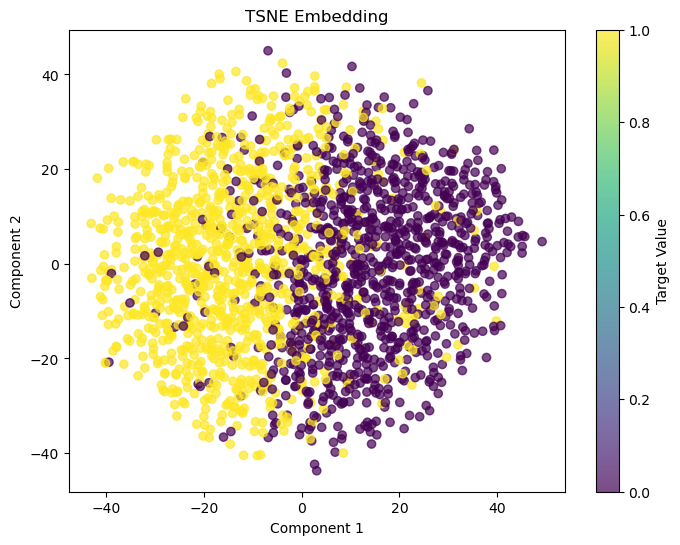

Executing -- MDS...
Executing function--Params: {'normalized_stress': False, 'n_components': 3} => AMI Score: 0.1632
Mean Accuracy: 0.8630 ± 0.0151


'MDS Accuracy: 0.8630 ± 0.0151'

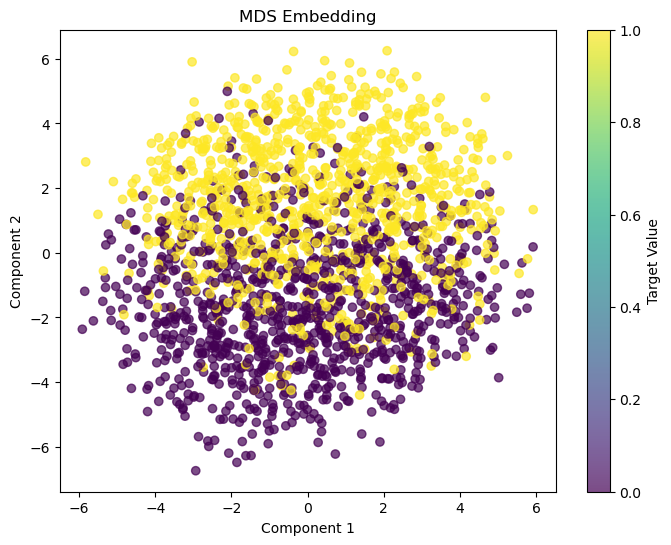

Executing -- Isomap...
Executing function--Params: {'n_components': 3} => AMI Score: 0.2562
Mean Accuracy: 0.8540 ± 0.0216


'Isomap Accuracy: 0.8540 ± 0.0216'

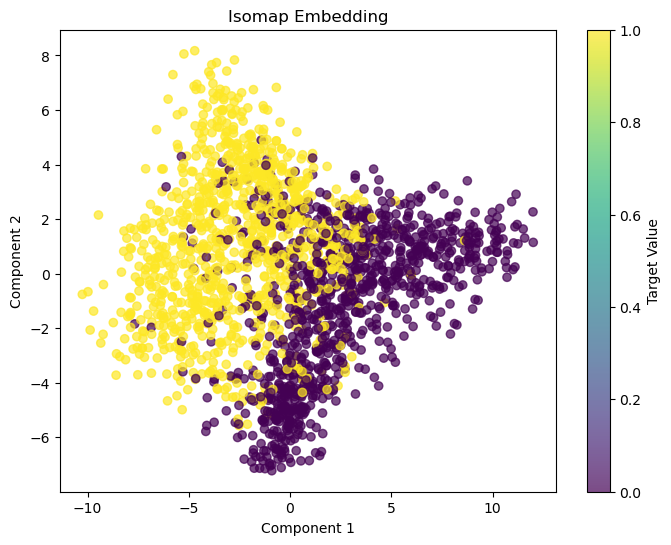

Executing -- GaussianRandomProjection...
Executing function--Params: {'n_components': 3} => AMI Score: 0.0578
Mean Accuracy: 0.5565 ± 0.0215


'GaussianRandomProjection Accuracy: 0.5565 ± 0.0215'

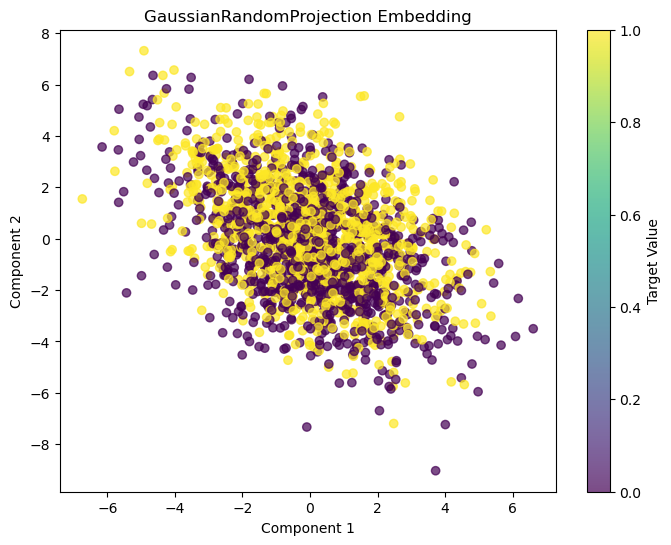

Executing -- SparseRandomProjection...
Executing function--Params: {'n_components': 3} => AMI Score: 0.0273
Mean Accuracy: 0.6705 ± 0.0133


'SparseRandomProjection Accuracy: 0.6705 ± 0.0133'

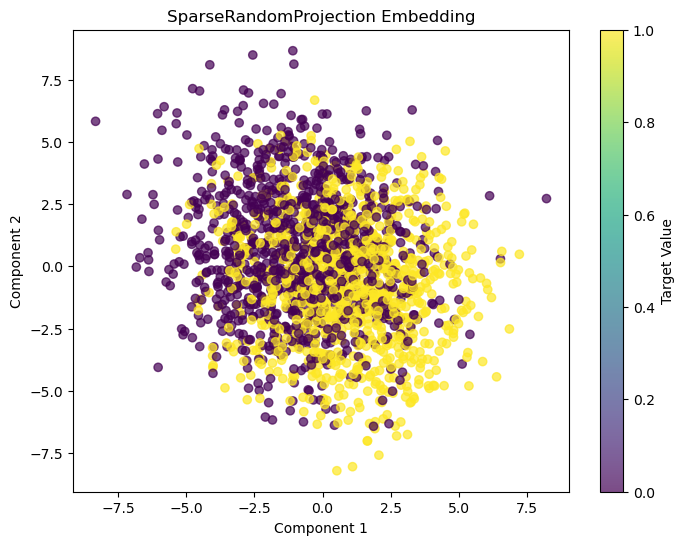

Executing -- SpectralEmbedding...
Executing function--Params: {'n_components': 3} => AMI Score: 0.1426
Mean Accuracy: 0.8935 ± 0.0179


'SpectralEmbedding Accuracy: 0.8935 ± 0.0179'

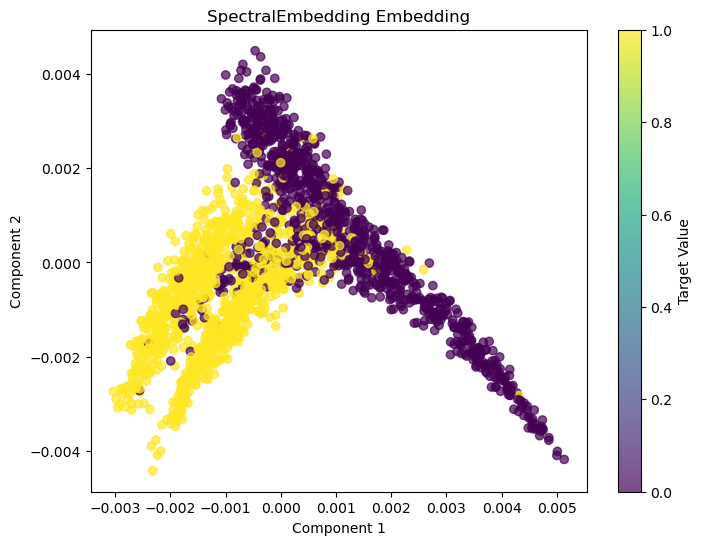

Executing -- LocallyLinearEmbedding...
Executing function--Params: {'n_components': 3} => AMI Score: 0.0388
Mean Accuracy: 0.8415 ± 0.0203


'LocallyLinearEmbedding Accuracy: 0.8415 ± 0.0203'

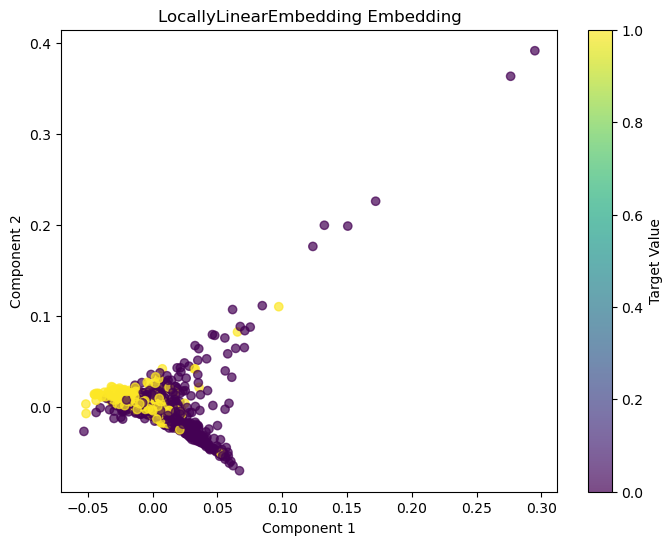

Executing -- RandomTreesEmbedding...
Error with params {'n_estimators': 20}: np.matrix is not supported. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
No valid parameters found for RandomTreesEmbedding, skipping...
Executing -- TruncatedSVD...
Executing function--Params: {} => AMI Score: 0.0778
Mean Accuracy: 0.8105 ± 0.0165


'TruncatedSVD Accuracy: 0.8105 ± 0.0165'

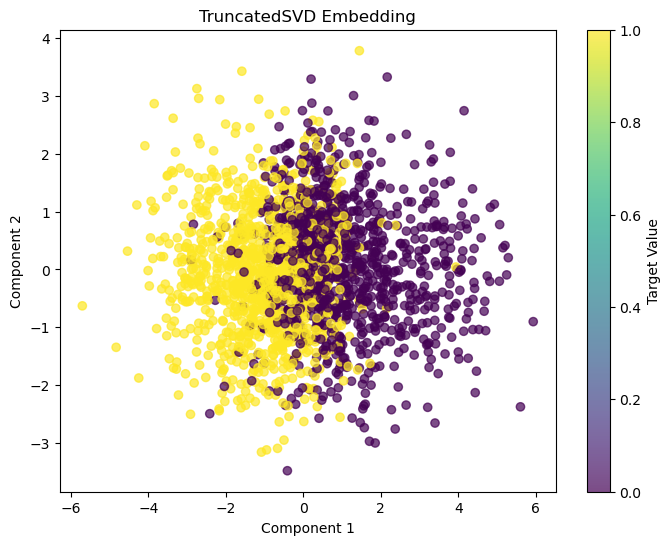

Executing -- KernelPCA...
Executing function--Params: {'n_components': 3} => AMI Score: 0.0756
Mean Accuracy: 0.8715 ± 0.0151


'KernelPCA Accuracy: 0.8715 ± 0.0151'

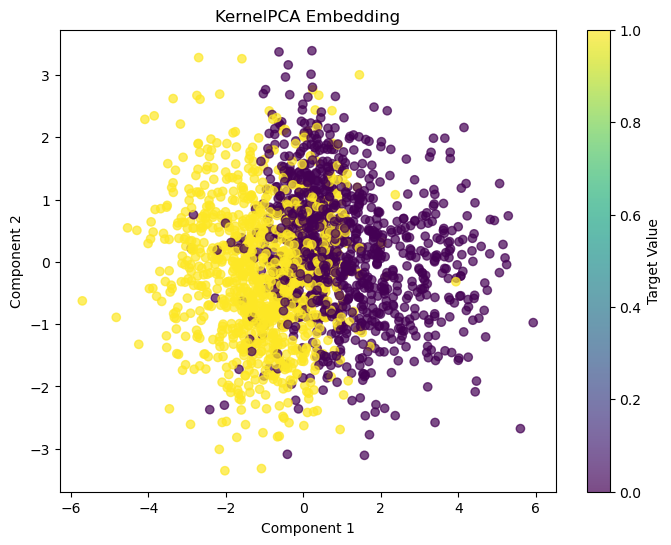

In [14]:
results = []

for model_name, (model, param_grid) in models.items():
    print(f"Executing -- {model_name}...")

    # Trova i migliori parametri con best_manifold
    best = best_manifold(X_std, y, model, param_grid, n_iter= 1)
    best_params = best['Best Params']

    if best_params is None:
        print(f"No valid parameters found for {model_name}, skipping...")
        continue  # per finire il loop
    
    X_embedded = model(**best_params).fit_transform(X_std)
    
    accuracy, std_dev = evaluate_with_kfold(svm_model, X_embedded, y)
    results.append((model_name, accuracy, std_dev, best_params)) 

    display(f"{model_name} Accuracy: {accuracy:.4f} ± {std_dev:.4f}")
    visualize_embedding(X_embedded, y, f"{model_name} Embedding")

In [15]:
results.sort(key=lambda x: x[1], reverse=True)
print("Models ranked by accuracy:")
for model_name, accuracy, std_dev, params in results:
    print(f"{model_name}: {accuracy:.4f} ± {std_dev:.4f} - Params: {params}")

Models ranked by accuracy:
SpectralEmbedding: 0.8935 ± 0.0179 - Params: {'n_components': 3}
KernelPCA: 0.8715 ± 0.0151 - Params: {'n_components': 3}
MDS: 0.8630 ± 0.0151 - Params: {'normalized_stress': False, 'n_components': 3}
Isomap: 0.8540 ± 0.0216 - Params: {'n_components': 3}
TSNE: 0.8500 ± 0.0196 - Params: {'n_components': 3}
LocallyLinearEmbedding: 0.8415 ± 0.0203 - Params: {'n_components': 3}
TruncatedSVD: 0.8105 ± 0.0165 - Params: {}
SparseRandomProjection: 0.6705 ± 0.0133 - Params: {'n_components': 3}
GaussianRandomProjection: 0.5565 ± 0.0215 - Params: {'n_components': 3}
